# ISE 529 FINAL PROJECT, Wednesday
### Group Member:
#### Lu Liu, USC ID: 8341358030
#### Yuanhui Zhang, USC ID: 6289628969
#### Jiawen Zhang, USC ID: 5158163752
#### Qianling Bai, USC ID: 2886884406

# Project: Home Credit Default Risk

# Probelm Description & Overview of Approach

#### Problem Description

The goal of this project is to deploy machine learning models to detect potential default by using client information data. The client information includes number of employement days, days of birth and so on. The total number of client features is more than 100. The main problems of this project can be a large amount of missing values, imbalanced datasets and curse of dimensions after applying one hot encoding to categorical features. 

Note about target variable:
( 0 for the loan was repaid on time; 1 indicating that the client had payment difficulties)

##### Overall Approach

1. We import data, explore features, check missing values, and observe target variables.

2. After understanding a large number of missing values, we decide to use XGBoost and LightGBM for training. We might impute missing values to specific features after feature selection

3. We use three feature selection methods that are univariate, wrapper, and embedded. We obtain votes for features from those selection methods and select features more than one vote.

4. The above feature selection methods do not consider the features with missing values more than 15% since some machine learning techniques like logistic regression cannot computer with a lot of missing values. We use correlation methods to find features with high correlation to target and do not consider if the feature has a lot of missing values.

5. We use min-max scale method for feature scaling and then train xgboost and lightGBM models with selected numerical and categorical features.

6. We subsampled data to make 1s and 0s in target train to be 50:50. We use new datasets to train the model.

7. We use grid search and k fold cross validation to tune hyperparameters. We use new hyperparameters to train the models.


## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline

## Import Data

In [2]:
df = pd.read_csv('application_train.csv',index_col = 0)

In [3]:
df.shape

(307511, 121)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Columns: 121 entries, TARGET to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 286.2+ MB


# Data Screening
### Check Missing Values

In [5]:
def missing_table(df):
    """Display the number of missing values and percentage in each features"""
    missing_series = df.isnull().sum()
    missing_percentage = df.isnull().sum()/len(df)*100
    missing_df = pd.concat([missing_series,missing_percentage],axis=1)
    missing_df.columns = ['missing_values','missing_percentage(%)']
    missing_df.sort_values(by = 'missing_percentage(%)', ascending=False, inplace = True)
    return missing_df

In [6]:
missing_df = missing_table(df)
missing_df.head(20)

,missing_values,missing_percentage(%)
COMMONAREA_AVG,214865,69.872297
COMMONAREA_MODE,214865,69.872297
COMMONAREA_MEDI,214865,69.872297
NONLIVINGAPARTMENTS_AVG,213514,69.432963
NONLIVINGAPARTMENTS_MODE,213514,69.432963
NONLIVINGAPARTMENTS_MEDI,213514,69.432963
FONDKAPREMONT_MODE,210295,68.386172
LIVINGAPARTMENTS_MEDI,210199,68.354953
LIVINGAPARTMENTS_AVG,210199,68.354953
LIVINGAPARTMENTS_MODE,210199,68.354953


## Check if our target is imbalanced or not. 

Text(0, 0.5, 'Frequency')

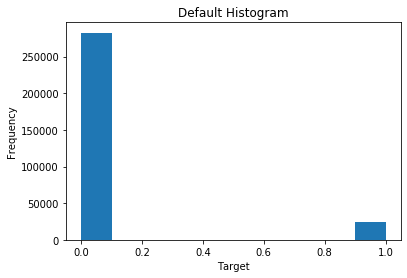

In [7]:
df['TARGET'].plot.hist(title = 'Default Histogram' )
plt.xlabel('Target')
plt.ylabel('Frequency')

As we can see the above graph, we have significantly more zeros than ones. 


Therefore we might use balanced accuracy to measure unbalanced datasets or subsampling data to balance datasets.

# Treatment of NA values, encoding of categorical features.

## Treatment of NA values

As we can see, there are a lot of missing values and features. There are some actions we are going to take for handling missing values and reducing features. 

1. We might use XGBoost and LightGBM to train the datasets because XGBoost and lightGBM treat missing values in the same way as XGBoost treats zeros in sparse matrices; it ignores the zero values and allocates them to whichever sides that reduces the loss most. 


2. We will impute the missing values with median values.

3. We will use univariate, wrapper, and embedded methods for feature selection.

## One Hot Encoding and NA rows dropped
To use feature selection methods, we need to prepare the dataset with less missing values, otherwise the machine learning methods such as logistic regression cannot process properly.

Since we have a lot of missing values of features, we need to extract features with missing values less than 15%.
We find out if our missing percentage threshold is 15%, we will eliminate 40 features but we keep a large portion of datasets.

In [8]:
feature_idx = missing_df[missing_df['missing_percentage(%)']<=15].index
feature_train = df[feature_idx]
feature_train.dropna(inplace = True)

target_train = feature_train['TARGET']

feature_train = feature_train.drop('TARGET',axis=1)
feature_train = pd.get_dummies(feature_train, drop_first = True)

Handle Categorical features (transform whole dataframe)

In [9]:
df_temp = pd.get_dummies(df, drop_first = True)
df_temp.shape, feature_train.shape

((307511, 229), (263423, 152))

# Dimension Reduction
Since we have more than 100 features, we need to reduce dimensions and select or extact key features from training datasets.

Method 1: ANOVA F-value from Univariate selection

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
f_class = SelectKBest(f_classif,k=10)
f_class.fit(feature_train,np.ravel(target_train))
f_support = f_class.get_support()
f_feature = feature_train.loc[:,f_support].columns.tolist()
f_feature

['EXT_SOURCE_2',
 'DAYS_LAST_PHONE_CHANGE',
 'REG_CITY_NOT_WORK_CITY',
 'REGION_RATING_CLIENT_W_CITY',
 'REGION_RATING_CLIENT',
 'DAYS_ID_PUBLISH',
 'DAYS_BIRTH',
 'CODE_GENDER_M',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education']

Method 2. Recursive Feature Eliminatin from Wrapper method 

In [11]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(solver = 'lbfgs',max_iter = 4000),
                   n_features_to_select = 10,step = 10,verbose = 5)
rfe_selector.fit(feature_train,target_train)
rfe_support = rfe_selector.get_support()
rfe_feature = feature_train.loc[:,rfe_support].columns.tolist()
rfe_feature

Fitting estimator with 152 features.
Fitting estimator with 142 features.
Fitting estimator with 132 features.
Fitting estimator with 122 features.
Fitting estimator with 112 features.
Fitting estimator with 102 features.
Fitting estimator with 92 features.
Fitting estimator with 82 features.
Fitting estimator with 72 features.
Fitting estimator with 62 features.
Fitting estimator with 52 features.
Fitting estimator with 42 features.
Fitting estimator with 32 features.
Fitting estimator with 22 features.
Fitting estimator with 12 features.


['AMT_GOODS_PRICE',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'HOUR_APPR_PROCESS_START',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH']

Method 3. Lassor, Random Forest, and XGBoost from embedded method

In [12]:
from sklearn.feature_selection import SelectFromModel
embbed_lr = SelectFromModel(LogisticRegression(solver = 'liblinear',penalty = 'l1'),max_features = 10)
embbed_lr.fit(feature_train,target_train)
emb_lr = embbed_lr.get_support()
emb_fea = feature_train.loc[:,emb_lr].columns.tolist()
emb_fea

['EXT_SOURCE_2',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_17',
 'FLAG_MOBIL',
 'REGION_POPULATION_RELATIVE',
 'ORGANIZATION_TYPE_Industry: type 12',
 'ORGANIZATION_TYPE_XNA',
 'NAME_INCOME_TYPE_Pensioner']

In [13]:
from sklearn.ensemble import RandomForestClassifier
emb_rf_sel = SelectFromModel(RandomForestClassifier(n_estimators = 100),max_features = 10)
emb_rf_sel.fit(feature_train,target_train)
emb_rf_sup = emb_rf_sel.get_support()
emb_rf_fea = feature_train.loc[:,emb_rf_sup].columns.tolist()
emb_rf_fea

['EXT_SOURCE_2',
 'AMT_ANNUITY',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'DAYS_ID_PUBLISH',
 'DAYS_REGISTRATION',
 'DAYS_EMPLOYED',
 'DAYS_BIRTH',
 'REGION_POPULATION_RELATIVE']

In [14]:
from xgboost import XGBClassifier
xgbc = XGBClassifier(n_estimators = 500,learning_rate = 0.05,
                     num_leaves = 32,colsample_bytree = 0.2,
                     reg_alpha = 3,reg_lambda = 1,
                     min_split_gain = 0.01,min_child_weight = 40)
emb_xgb_sel = SelectFromModel(xgbc,max_features = 10)
emb_xgb_sel.fit(feature_train,target_train)
emb_xgb_sup = emb_xgb_sel.get_support()
emb_xgb_fea = feature_train.loc[:,emb_xgb_sup].columns.tolist()
emb_xgb_fea

['EXT_SOURCE_2',
 'REG_CITY_NOT_WORK_CITY',
 'FLAG_EMP_PHONE',
 'DAYS_EMPLOYED',
 'CODE_GENDER_M',
 'ORGANIZATION_TYPE_XNA',
 'NAME_INCOME_TYPE_Pensioner',
 'NAME_INCOME_TYPE_Working',
 'NAME_EDUCATION_TYPE_Higher education',
 'NAME_EDUCATION_TYPE_Secondary / secondary special']

### Display vote dataframe from above selection methods

In [15]:
vote_df = pd.DataFrame({"Feature":feature_train.columns,
                        "Random Forest":emb_rf_sup,
                        "Lasso":emb_lr,
                        "RFE":rfe_support,
                        "XGBoost":emb_xgb_sup,
                        "f_classif":f_support})

In [16]:
vote_df['total'] = np.sum(vote_df,axis = 1)
vote_df = vote_df.sort_values(['total','Feature'],ascending = False)
vote_df.head(20) 

,Feature,Random Forest,Lasso,RFE,XGBoost,f_classif,total
10,EXT_SOURCE_2,True,True,False,True,True,4
14,DAYS_LAST_PHONE_CHANGE,True,False,True,False,True,3
53,DAYS_ID_PUBLISH,True,False,True,False,True,3
55,DAYS_EMPLOYED,True,False,True,True,False,3
56,DAYS_BIRTH,True,False,True,False,True,3
39,REG_CITY_NOT_WORK_CITY,False,False,False,True,True,2
57,REGION_POPULATION_RELATIVE,True,True,False,False,False,2
124,ORGANIZATION_TYPE_XNA,False,True,False,True,False,2
131,NAME_INCOME_TYPE_Working,False,False,False,True,True,2
127,NAME_INCOME_TYPE_Pensioner,False,True,False,True,False,2


# Feature Selection

### We select features with more than one vote from the above dataframe

In [17]:
feature_model_idx = vote_df[vote_df.total > 1]['Feature']
features_16 = feature_train[feature_model_idx]

### Check correlations between target and each of features
 Since last step we filter features with missing values less than 15%, we might lose some important features with missing values more than 15%.

Therefore we want to use the method of correlation between target and each of features to explore important features.

In [18]:
correlations = df_temp.corr()['TARGET'].sort_values()
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 DAYS_REGISTRATION                                    0.041975
OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### Find features that have high correlation with target but not in the last updated feature list.

In [19]:
hcorr_list = correlations.head(15).index.tolist() + correlations.tail(15).index.tolist()
dropped_idx = missing_df[missing_df['missing_percentage(%)']>15].index
dropped_selection = set(dropped_idx.tolist()) & set(hcorr_list)
dropped_selection

{'ELEVATORS_AVG',
 'ELEVATORS_MEDI',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'FLOORSMAX_AVG',
 'FLOORSMAX_MEDI',
 'FLOORSMAX_MODE',
 'FLOORSMIN_AVG'}

Display those features and check their missing values

In [20]:
missing_df.loc[list(dropped_selection)]

,missing_values,missing_percentage(%)
FLOORSMAX_MEDI,153020,49.760822
FLOORSMAX_AVG,153020,49.760822
FLOORSMAX_MODE,153020,49.760822
ELEVATORS_MEDI,163891,53.295980
ELEVATORS_AVG,163891,53.295980
FLOORSMIN_AVG,208642,67.848630
EXT_SOURCE_1,173378,56.381073
EXT_SOURCE_3,60965,19.825307


### We append those features to our feature list

In [21]:
five_features = df_temp[dropped_selection]
feature_train = pd.concat([features_16,five_features.loc[feature_train.index]], axis=1)

In [22]:
feature_train.columns

Index(['EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'DAYS_EMPLOYED', 'DAYS_BIRTH', 'REG_CITY_NOT_WORK_CITY',
       'REGION_POPULATION_RELATIVE', 'ORGANIZATION_TYPE_XNA',
       'NAME_INCOME_TYPE_Working', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_EDUCATION_TYPE_Higher education', 'DAYS_REGISTRATION',
       'CODE_GENDER_M', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'EXT_SOURCE_1', 'EXT_SOURCE_3'],
      dtype='object')

## Get key feature data from the dataframe 

### Transform days of birth to age

In [23]:
feature_train['Age'] = feature_train['DAYS_BIRTH']/-365
feature_train['Age'].astype(int).head()
feature_train.drop(['DAYS_BIRTH'],inplace=True, axis=1)

# Plots with high quality

In [24]:
plot_data1 = pd.concat([target_train, feature_train],axis=1)

### Prepare numerical data for min-max scale

In [25]:
feature_sca_names = feature_train.dtypes[(feature_train.dtypes==np.float64) 
                                   | (feature_train.dtypes==np.int64)].index.tolist()
feature_sca = feature_train[feature_sca_names]

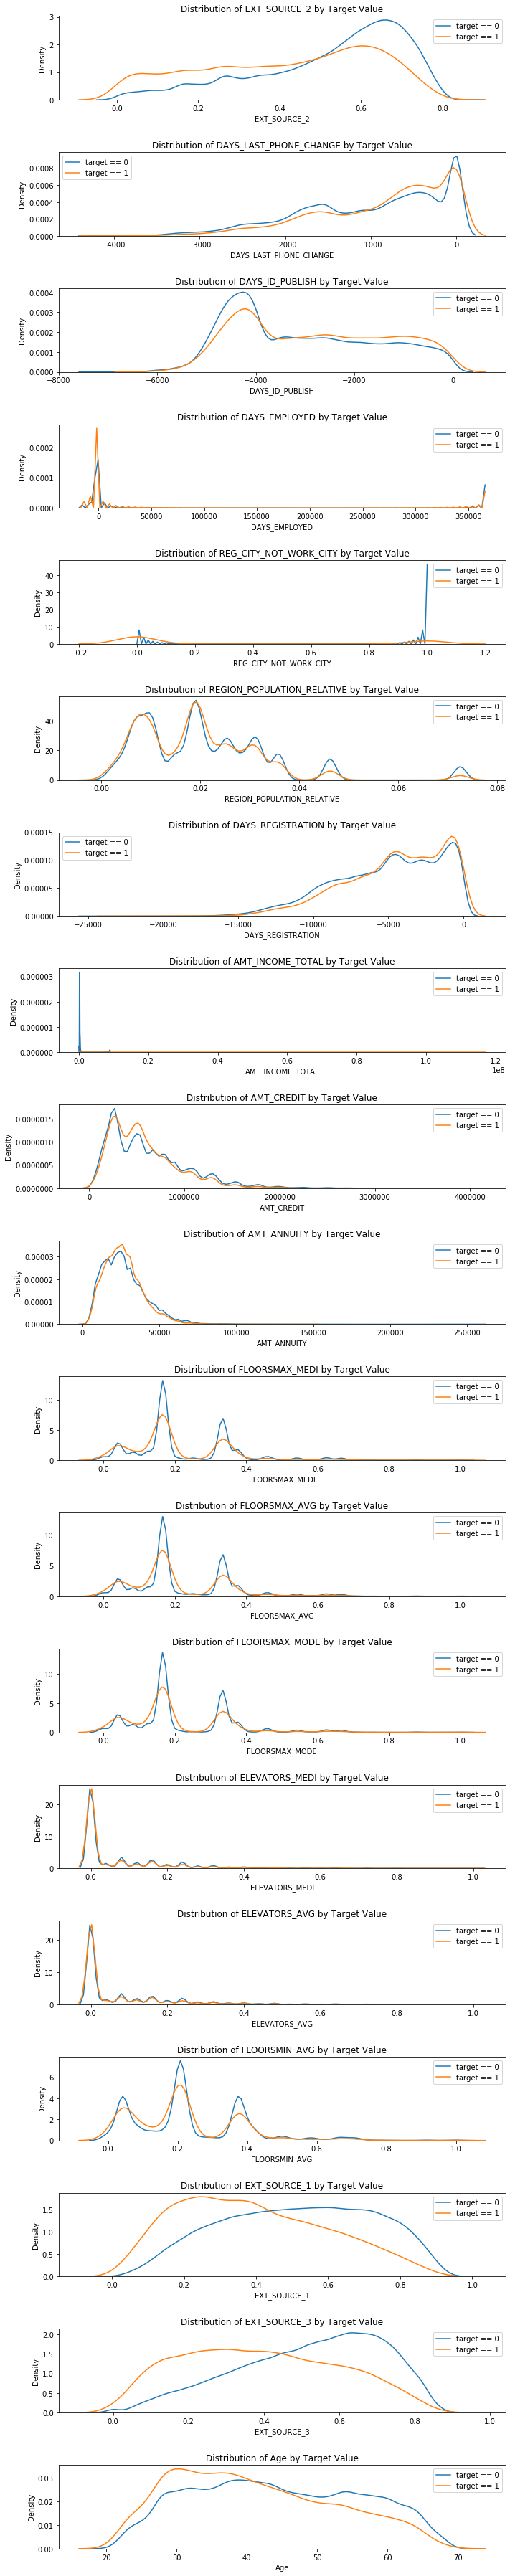

In [26]:
plt.figure(figsize = (10, 50))

# iterate through the sources
for i, source in enumerate(feature_sca_names):
    
    # create a new subplot for each source
    plt.subplot(feature_sca.shape[1], 1, i + 1)
    # plot repaid loans
    sns.kdeplot(plot_data1.loc[plot_data1['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(plot_data1.loc[plot_data1['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
plt.tight_layout(h_pad = 2.5)  

# Feature Construction

### Feature construction by domain knowledge 

In [27]:
feature_train['CREDIT_INCOME_PERCENT'] = feature_train['AMT_CREDIT'] / feature_train['AMT_INCOME_TOTAL']
feature_train['ANNUITY_INCOME_PERCENT'] = feature_train['AMT_ANNUITY'] / feature_train['AMT_INCOME_TOTAL']
feature_train['CREDIT_TERM'] = feature_train['AMT_ANNUITY'] / feature_train['AMT_CREDIT']
feature_train['DAYS_EMPLOYED_PERCENT'] = feature_train['DAYS_EMPLOYED'] / (feature_train['Age']*(-365))

# Feature Scaling
### Min-max scale

In [28]:
scaler = MinMaxScaler()
feature_after_sca = scaler.fit_transform(feature_sca)
feature_after_sca_df = pd.DataFrame(feature_after_sca, 
                                 columns = feature_sca_names, 
                                 index = feature_train.index)

### Combine feature train datasets

In [29]:
feature_cat = feature_train.dtypes[feature_train.dtypes==np.uint8].index.tolist()
feature_cat_df = feature_train[feature_cat]
train_data = pd.concat([feature_after_sca_df,feature_cat_df],axis=1)

## Display Features We Selected

In [30]:
train_data.columns

Index(['EXT_SOURCE_2', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH',
       'DAYS_EMPLOYED', 'REG_CITY_NOT_WORK_CITY', 'REGION_POPULATION_RELATIVE',
       'DAYS_REGISTRATION', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'FLOORSMAX_MEDI', 'FLOORSMAX_AVG', 'FLOORSMAX_MODE', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'FLOORSMIN_AVG', 'EXT_SOURCE_1', 'EXT_SOURCE_3', 'Age',
       'ORGANIZATION_TYPE_XNA', 'NAME_INCOME_TYPE_Working',
       'NAME_INCOME_TYPE_Pensioner', 'NAME_EDUCATION_TYPE_Higher education',
       'CODE_GENDER_M'],
      dtype='object')

# Impute missing values with median
We found out "external source 3" has 19% missing value and it is relatively lower than others, but it is key to detect default, so we only impute its missing values with median, and we left other missing value to be handled by XGBoost and LightGBM models.

In [31]:
train_data['EXT_SOURCE_3'] = train_data['EXT_SOURCE_3'].replace(np.nan, train_data['EXT_SOURCE_3'].median())

# Model Selection

### We might use XGBoost and LightGBM to train the datasets because XGBoost and lightGBM treat missing values in the same way as XGBoost treats zeros in sparse matrices; it ignores the zero values and allocates them to whichever sides that reduces the loss most. 

## Model Training

### Split train and test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_data, target_train, test_size = 0.3, random_state=1)

### Add accuracy function

In [33]:
def accuracy(model, X_test = X_test, y_test = y_test):
    """Use accuracy of confusion matrix to evaluate model performance"""
    y_hat = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat)
    print(("Accuracy Rate is {}".format((conf_mat[0][0]+conf_mat[1][1])/conf_mat.sum())))
    return (conf_mat[0][0]+conf_mat[1][1])/conf_mat.sum()

def balanced_accuracy(model, X_test = X_test, y_test = y_test):
    y_hat = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat)
    TPR = conf_mat[1][1] / (conf_mat[1][1]+conf_mat[1][0])
    TNR = conf_mat[0][0] / (conf_mat[0][0]+conf_mat[0][1])
    print(("Balanced Accuracy Rate is {}".format((TPR+TNR)/2)))
    return (TPR+TNR)/2

### XGBoost Model

In [34]:
xgb = XGBClassifier(max_depth=20, 
                    learning_rate=0.1, 
                    n_estimators=100, 
                    random_state=1).fit(X_train, y_train)
xgb_acc = accuracy(xgb)

Accuracy Rate is 0.9234945018791046


In [35]:
xgb_bala = balanced_accuracy(xgb)

Balanced Accuracy Rate is 0.5113818603202543


### LightGBM Model

In [36]:
lgbm = LGBMClassifier(max_depth=20, 
                      learning_rate=0.1,
                      n_estimators=100,
                      random_state=1).fit(X_train, y_train)
lgbm_acc = accuracy(lgbm)

Accuracy Rate is 0.9242157743556


In [37]:
lgbm_bala = balanced_accuracy(lgbm)

Balanced Accuracy Rate is 0.5056700206969018


There is a significant gap between accuracy rate and balanced accuracy rate, so it is crucial to use balanced 
datasets to train the model.

### Since we have imbalance datasets, we use undersampled technique to balance target to 50 and 50

In [38]:
X = pd.concat([X_train, y_train], axis=1)
default_1 = X[X.TARGET==1]
non_default_0 = X[X.TARGET==0]
non_default_under = resample(non_default_0,
        replace=False,
        n_samples = len(default_1),
        random_state = 1)
downsampled = pd.concat([non_default_under,default_1])
downsampled.TARGET.value_counts()

1    14392
0    14392
Name: TARGET, dtype: int64

#### We use balanced data to train the XGBoost and LightGBM model again.

In [39]:
dn_ytrain = downsampled.TARGET
dn_xtrain = downsampled.drop('TARGET',axis=1)
dn_xtrain.shape

(28784, 24)

In [40]:
xgb_dn = XGBClassifier(max_depth=20, 
                       learning_rate=0.1, 
                       n_estimators=100, 
                       random_state=1).fit(dn_xtrain,dn_ytrain)

In [41]:
xgb_acc = accuracy(xgb_dn)

Accuracy Rate is 0.675946195604034


In [42]:
lgbm_dn = LGBMClassifier(learning_rate=0.1,
                        num_leaves = 10,
                         n_estimators=20,
                        objective='binary',
                        reg_alpha=0.1,
                        reg_lambda=0.1,
                        random_state=50).fit(dn_xtrain,dn_ytrain)

In [43]:
lgbm_acc = accuracy(lgbm_dn)

Accuracy Rate is 0.6812102192921407


# Hyperparameter Tuninig
We use k-fold cross validation to tune our hyperparameters.

### XGBoost with k-fold cross validation

In [44]:
param_test1 = {'learning_rate':np.linspace(0.05,0.1,2),
               'max_depth':range(3,10,2),
               'min_child_weight':range(1,6,2),
               'n_estimators': range(20,80,10)
}

model = XGBClassifier()
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
gsearch1 = GridSearchCV(estimator = model, 
                        param_grid = param_test1, scoring='roc_auc',
                        n_jobs=4,iid=False, cv=kfold)

gsearch1.fit(dn_xtrain, dn_ytrain)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objec...,
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=4,
             param_grid={'learning_rate': array([0.05, 0.1 ]),
                         'max_depth': range(3, 10, 2),
  

In [45]:
gsearch1.best_params_, gsearch1.best_score_

({'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 70},
 0.7499201518797451)

In [46]:
xgb_dn = XGBClassifier(max_depth=5, 
                       learning_rate=0.1, 
                       n_estimators=70, 
                       min_child_weight=3,
                       random_state=1).fit(dn_xtrain,dn_ytrain)
xgb_acc = accuracy(xgb_dn)

Accuracy Rate is 0.6899161046224708


### LightGBM with k-fold cross validation

In [47]:
gridParams = {
    'learning_rate': [0.1],
    'n_estimators': range(20,80,10),
    'num_leaves': [6,8,12,16],
    'boosting_type' : ['gbdt'],
    'objective' : ['binary'],
    'random_state':[501],
    'colsample_bytree':[0.65,0.66],
    'subsample':[0.7,0.75],
    'reg_alpha':[1,1.2],
    'reg_lambda':[1,1.2,1.4]
}

mdl = LGBMClassifier()

grid = GridSearchCV(mdl, gridParams, 
                    verbose=2, cv=kfold, 
                    scoring='roc_auc', 
                    n_jobs=-1, refit='AUC')

grid.fit(dn_xtrain, dn_ytrain)

Fitting 10 folds for each of 576 candidates, totalling 5760 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  29 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 150 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 353 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 636 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1001 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 1446 tasks      | elapsed:   47.7s
[Parallel(n_jobs=-1)]: Done 1973 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2580 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 3269 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4038 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4889 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 5760 out of 5760 | elapsed:  3.7min finished


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=1, shuffle=True),
             error_score='raise-deprecating',
             estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None,
                                      colsample_bytree=1.0,
                                      importance_type='split',
                                      learning_rate=0.1, max_depth=-1,
                                      min_child_samples=20,
                                      min_child_weight=0.001,
                                      min_split_gain=0.0, n_estimators=100,
                                      n_jobs=-1, num_leaves=31, o...
             iid='warn', n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'colsample_bytree': [0.65, 0.66],
                         'learning_rate': [0.1],
                         'n_estimators': range(20, 80, 10),
                         'num_leaves': [6, 8, 12, 16], 'objective': ['binary'],
  

In [48]:
grid.best_params_

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'learning_rate': 0.1,
 'n_estimators': 70,
 'num_leaves': 16,
 'objective': 'binary',
 'random_state': 501,
 'reg_alpha': 1,
 'reg_lambda': 1.4,
 'subsample': 0.7}

In [49]:
lgbm_dn = LGBMClassifier(boosting_type ='gbdt', 
                         colsample_bytree = 0.65,
                         learning_rate = 0.1,
                         n_estimators =  70,
                         num_leaves = 16,
                         objective='binary',
                         random_state = 501,
                         reg_alpha =  1.2,
                         reg_lambda =  1.4,
                         subsample = 0.7).fit(dn_xtrain,dn_ytrain)
lgbm_acc = accuracy(lgbm_dn)

Accuracy Rate is 0.6890429853088185


## After tuning hyperparameters, the accuracy improved.

## Our algorithms are limited to XGBoost and LightGBM due to missing values. At this step, we will fill missing values with median of each column and then we try new models to predict.

In [50]:
dn_xtrain_wona = dn_xtrain.copy()
dn_xtrain_wona.fillna(dn_xtrain_wona.median(), inplace=True)
X_test_wona = X_test.copy()
X_test_wona.fillna(X_test_wona.median(), inplace=True)
dn_xtrain_wona.isna().sum()

def accuracy_wona(model, X_test = X_test_wona, y_test = y_test):
    """Use accuracy of confusion matrix to evaluate model performance"""
    y_hat = model.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_hat)
    print(("Accuracy Rate is {}".format((conf_mat[0][0]+conf_mat[1][1])/conf_mat.sum())))
    return (conf_mat[0][0]+conf_mat[1][1])/conf_mat.sum()

### Logistic Regression

In [51]:
lr = LogisticRegression().fit(dn_xtrain_wona,dn_ytrain)
lr_acc = accuracy_wona(lr)

Accuracy Rate is 0.7026206233312665


### Random Forest

In [52]:
rf = RandomForestClassifier().fit(dn_xtrain_wona,dn_ytrain)
rf_acc = accuracy_wona(rf)

Accuracy Rate is 0.7315221380034672


## Hyperparameters Tuning for Logistic Regression and Random Forest

In [53]:
param_grid ={'penalty' : ['l1', 'l2'],
             'C' : np.logspace(-4, 4, 20),
             'solver' : ['liblinear']},

lr_opt = GridSearchCV(LogisticRegression(), 
                      param_grid = param_grid, 
                      cv = 5, verbose=True, n_jobs=-1)
lr_opt.fit(dn_xtrain_wona, dn_ytrain)  
lr_opt.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.5min finished


{'C': 206.913808111479, 'penalty': 'l2', 'solver': 'liblinear'}

In [54]:
param_grid_2 = {'n_estimators' : list(range(10,101,10)),
                'max_features' : list(range(5,15,5))}

rf_opt = GridSearchCV(RandomForestClassifier(), 
                   param_grid = param_grid_2, 
                   cv = 5, verbose=True, n_jobs=-1)
rf_opt.fit(dn_xtrain_wona, dn_ytrain)
rf_opt.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.1min finished


{'max_features': 5, 'n_estimators': 70}

## Training Model

In [55]:
lr_opti = LogisticRegression(C=3792, 
                             penalty='l1', 
                             solver='liblinear').fit(dn_xtrain_wona,dn_ytrain)
lr_opti_acc = accuracy_wona(lr_opti)

Accuracy Rate is 0.7030761638427373


In [56]:
rf_opti = RandomForestClassifier(max_features=5,
                                 n_estimators=100).fit(dn_xtrain_wona, dn_ytrain)
rf_opti_acc = accuracy_wona(rf_opti)

Accuracy Rate is 0.7254229567109975


# Conclusion
We used four models for training our datasets. The highest accuracy is obtained by random forest model. Hence we will impute missing values with median and train the datasets by random forest model.

# Predict Test Data

In [57]:
test_data = pd.read_csv('test_data.csv',index_col=0)

In [58]:
results1 = pd.DataFrame(rf_opti.predict(test_data))

In [59]:
results1.to_csv('prediction.csv')